In [70]:
import pandas as pd
import numpy as np

In [71]:
train_df = pd.read_csv("./clean_credit_score_classification.csv")

C:\Users\ngova\AppData\Local\Temp\ipykernel_8956\367072628.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("./clean_credit_score_classification.csv")


In [72]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        150000 non-null  int64  
 1   Customer_ID               150000 non-null  int64  
 2   Month                     150000 non-null  int64  
 3   Name                      150000 non-null  object 
 4   Age                       150000 non-null  float64
 5   SSN                       150000 non-null  float64
 6   Occupation                150000 non-null  object 
 7   Annual_Income             150000 non-null  float64
 8   Monthly_Inhand_Salary     150000 non-null  float64
 9   Num_Bank_Accounts         150000 non-null  float64
 10  Num_Credit_Card           150000 non-null  float64
 11  Interest_Rate             150000 non-null  float64
 12  Num_of_Loan               150000 non-null  float64
 13  Type_of_Loan              150000 non-null  o

In [73]:
train_df.drop(['ID', 'Customer_ID', 'Name', 'SSN', 'Type_of_Loan'], axis=1, inplace=True)
train_df.dropna(inplace=True)
train_df.drop_duplicates(train_df.drop('Credit_Score', axis=1).columns,inplace=True)

In [74]:
train_df['Occupation'] = train_df['Occupation'].astype('category').cat.codes
train_df['Credit_Mix'] = train_df['Credit_Mix'].astype('category').cat.codes
train_df['Payment_Behaviour'] = train_df['Payment_Behaviour'].astype('category').cat.codes
train_df['Payment_of_Min_Amount'] = train_df['Payment_of_Min_Amount'].astype('category').cat.codes

<AxesSubplot:xlabel='Month'>

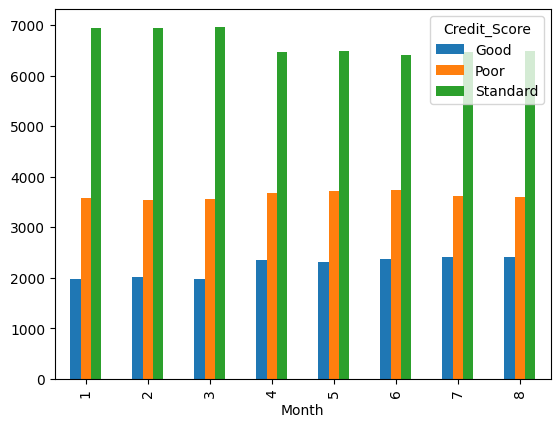

In [75]:
pd.crosstab(train_df['Month'], train_df['Credit_Score']).plot.bar()

In [76]:
train_df.drop('Month', axis=1, inplace=True)

In [77]:
labels = ["Poor", "Standard", "Good"]
train_df['Credit_Score'] = train_df['Credit_Score'].map(labels.index)

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [79]:
X = train_df.drop('Credit_Score', axis=1)
y = train_df['Credit_Score']
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

In [80]:
unique, counts = np.unique(y_train, return_counts=True)
y_dict = dict(zip(unique, counts))
class_weight = {0: 1 - y_dict[0]/len(y_train), 1: 1 - y_dict[1]/len(y_train), 2: 1 - y_dict[2]/len(y_train)}
#clf = RandomForestClassifier(n_estimators=100, criterion='gini', n_jobs=-1, verbose=100)
clf = DecisionTreeClassifier(criterion='gini', class_weight=None, random_state=36)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [81]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

pd.DataFrame(metrics.confusion_matrix(y_test, y_pred, labels=np.unique(y_test)), 
             index=['True ' + x for x in labels], 
             columns=['Predict ' + x for x in labels])

Accuracy: 0.73


,Predict Poor,Predict Standard,Predict Good
True Poor,4214,1539,76
True Standard,1513,7993,1041
True Good,110,1121,2393


In [82]:
important_features = {}
for name, value in zip(train_df.drop('Credit_Score', axis=1).columns, clf.feature_importances_):
  important_features[name] = value
important_features = dict(sorted(important_features.items(), key=lambda x: x[1]))
important_features

{'Payment_of_Min_Amount': 0.006299684256148301,
 'Num_of_Loan': 0.011178295389457154,
 'Num_Bank_Accounts': 0.01787150614692196,
 'Payment_Behaviour': 0.01886224543243979,
 'Occupation': 0.02563467006769843,
 'Num_Credit_Inquiries': 0.02580557107297826,
 'Num_Credit_Card': 0.026156789976362043,
 'Monthly_Inhand_Salary': 0.030889965489304033,
 'Annual_Income': 0.031259898865039215,
 'Num_of_Delayed_Payment': 0.034508895210116595,
 'Age': 0.036062459659860435,
 'Total_EMI_per_month': 0.04002040682674777,
 'Monthly_Balance': 0.051143294461524685,
 'Amount_invested_monthly': 0.052209196083615406,
 'Interest_Rate': 0.05606913645734791,
 'Changed_Credit_Limit': 0.05683245910414228,
 'Credit_Utilization_Ratio': 0.05689873031850774,
 'Delay_from_due_date': 0.0571464333262739,
 'Credit_History_Age': 0.0758957497163488,
 'Credit_Mix': 0.1163112075687238,
 'Outstanding_Debt': 0.17294340457044155}

In [83]:
accurate = []

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=36, shuffle=True)
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf = DecisionTreeClassifier(criterion='gini', class_weight=None, random_state=36)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accurate.append(metrics.accuracy_score(y_test, y_pred))

print(np.mean(accurate))

0.73151


In [84]:
# for c in train_df.drop('Credit_Score', axis=1):
#     X = train_df.drop(['Credit_Score', c], axis=1)
#     y = train_df['Credit_Score'].cat.codes

#     X = np.array(X)
#     y = np.array(y)
#     accurate = []

#     from sklearn.model_selection import KFold
#     kf = KFold(n_splits=5, random_state=36, shuffle=True)
#     for train_idx, test_idx in kf.split(X):
#         X_train, X_test = X[train_idx], X[test_idx]
#         y_train, y_test = y[train_idx], y[test_idx]
#         clf = DecisionTreeClassifier(criterion='gini', class_weight=None, random_state=36)
#         clf = clf.fit(X_train, y_train)
#         y_pred = clf.predict(X_test)
#         accurate.append(metrics.accuracy_score(y_test, y_pred))
        
#     print(f"{c}: {np.mean(accurate)}")

In [85]:
X = train_df.drop(['Credit_Score', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 
'Credit_Utilization_Ratio', 'Amount_invested_monthly', 'Monthly_Balance', 'Num_of_Loan',
'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Payment_of_Min_Amount', 'Payment_Behaviour'
], axis=1)
y = train_df['Credit_Score']

X = np.array(X)
y = np.array(y)
accurate = []

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=36, shuffle=True)
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf = DecisionTreeClassifier(criterion='gini', class_weight=None, random_state=36)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accurate.append(metrics.accuracy_score(y_test, y_pred))

print(f"accurate: {np.mean(accurate)}")


accurate: 0.81931


In [86]:
X = train_df.drop(['Credit_Score', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 
'Credit_Utilization_Ratio', 'Amount_invested_monthly', 'Monthly_Balance', 'Num_of_Loan',
'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Payment_of_Min_Amount', 'Payment_Behaviour'
], axis=1)
y = train_df['Credit_Score']
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=36)

clf = DecisionTreeClassifier(criterion='gini', class_weight=None, random_state=36)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred, labels=np.unique(y_test)), 
             index=['True ' + x for x in labels], 
             columns=['Predict ' + x for x in labels]))
print(metrics.classification_report(y_test, y_pred, target_names=labels))

               Predict Poor  Predict Standard  Predict Good
True Poor              4719              1102             8
True Standard          1088              8763           696
True Good                 4               789          2831
              precision    recall  f1-score   support

        Poor       0.81      0.81      0.81      5829
    Standard       0.82      0.83      0.83     10547
        Good       0.80      0.78      0.79      3624

    accuracy                           0.82     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.82      0.82      0.82     20000

